# **Fairness Analysis on Bank Marketing Dataset**

## **1. Context**
This analysis uses the Bank Marketing Dataset from the UCI Machine Learning Repository, specifically the file bank-full.csv, which contains data collected from a Portuguese bank's direct marketing campaign. The campaign involved phone calls to potential clients to promote subscriptions to term deposits.

Each row represents a client contacted during the campaign, along with personal and contact-related attributes.

- **Goal:** Predict whether a client will subscribe to a term deposit (y).
- **Source:** UCI Machine Learning Repository
Version Used: bank-full.csv — the older version containing 45,211 instances and 17 features (including the target).

- **Data Collection Method:** Telephone-based direct marketing.
- **Reference:** [Moro et al., 2014] 



## **2. Exploratory Data Analysis**
We analyze the distribution of the target variable, and explore subscription rates across various groups.


In [81]:
# Load Data and Inspect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np

# Load dataset
df_original = pd.read_csv("bank-full.csv", sep=";")
df = df_original.copy()

# Display dataset structure
print("\n🟢 Dataset Information:\n")
df.info()

# Show first few rows
print("\n🟢 First 5 Rows:\n")
print(df.head())

# Dataset shape
print("\n🟢 Dataset Shape:", df.shape)

# Check for missing values
print("\n🟢 Missing Values in Each Column:\n")
print(df.isnull().sum())

# Display basic statistics (only for numeric columns)
print("\n🟢 Summary Statistics:\n")
print(df.describe())



🟢 Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB

🟢 First 5 Rows:

   age           job  marital  education default  balanc

The UCI Bank Marketing dataset comprises 45,211 instances and 17 attributes, including demographic details such as age, job, marital status, education, and financial information like average yearly balance, housing loan status, and personal loan status. For analysis, we thought focusing on attributes like age, job, marital status, and education can provide us the most valuable insights into customer demographics and their potential impact on term deposit subscription rates.

## **2.1 Target Variable Distribution**
We examine the proportion of clients who subscribed (`yes`) versus those who didn't (`no`).


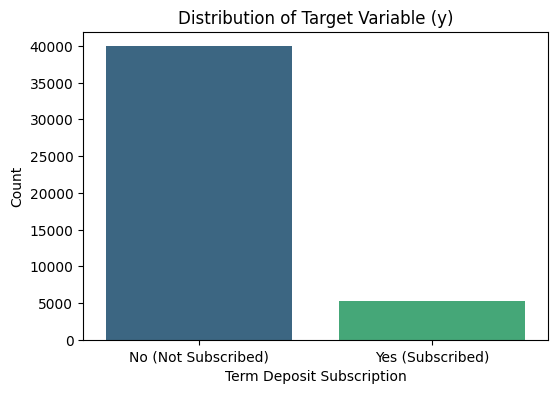


🔹 Subscription Rate: 11.70% (Proportion of 'Yes')



In [82]:
# Convert target variable to binary (0 = No, 1 = Yes)
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Plot target variable distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['y'], palette='viridis')
plt.xticks([0,1], ['No (Not Subscribed)', 'Yes (Subscribed)'])
plt.xlabel("Term Deposit Subscription")
plt.ylabel("Count")
plt.title("Distribution of Target Variable (y)")
plt.show()

# Print subscription rates
subscription_rate = df['y'].mean()
print(f"\n🔹 Subscription Rate: {subscription_rate:.2%} (Proportion of 'Yes')\n")


### Distribution of Target Variable (Subscription Outcome)

This bar chart illustrates the distribution of the target variable, representing whether clients subscribed to a term deposit. It highlights a strong **class imbalance**, where the majority of clients fall into the **"No (Not Subscribed)"** category, while only a small fraction are in the **"Yes (Subscribed)"** group. This imbalance, approximately **89% no vs. 11% yes**, can impact model performance by causing it to favor the dominant class, making it harder to correctly identify actual subscribers.

## **2.2 Subscription Rate by Age Group and Job Type**
We analyze how subscription rates vary across **age groups** and **job types**, which are relevant for fairness considerations.


In [83]:
# Compute 75th percentile of age
age_threshold = df['age'].quantile(0.75)
print(f"🔹 Age 75th Percentile (Threshold): {age_threshold:.0f}")

# Create binary age group: 1 = younger (< threshold), 0 = older (≥ threshold)
df['age_group'] = df['age'].apply(lambda x: 1 if x < age_threshold else 0)

# Compute subscription rates by age group
subscription_by_age_group = df.groupby('age_group')['y'].mean()

🔹 Age 75th Percentile (Threshold): 48


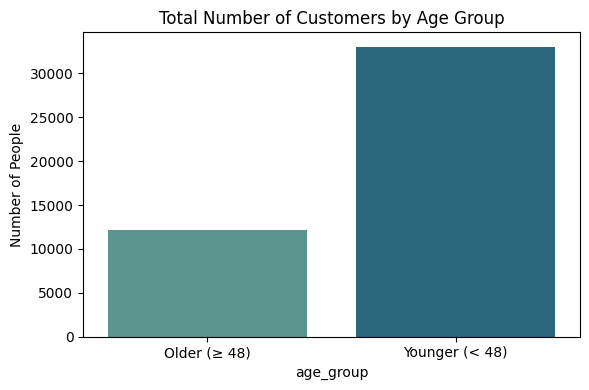

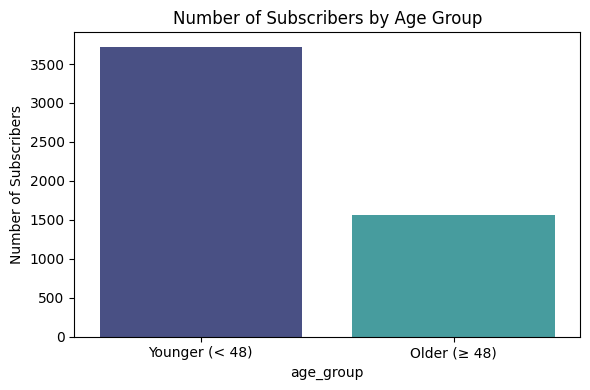

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define age threshold
age_threshold = df['age'].quantile(0.75)

# Step 2: Create readable age group column
df['age_group'] = df['age'].apply(lambda x: 'Younger (< 48)' if x < age_threshold else 'Older (≥ 48)')

# Step 3: Subscription rate per age group
subscription_rate_by_group = df.groupby('age_group')['y'].mean()

# Step 4: Count of subscribers in each group
subscribers_count = df[df['y'] == 1]['age_group'].value_counts()
# Count total people in each age group
total_counts = df['age_group'].value_counts().reindex(['Older (≥ 48)', 'Younger (< 48)'])

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=total_counts.index, y=total_counts.values, palette='crest')
plt.ylabel("Number of People")
plt.title("Total Number of Customers by Age Group")
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
sns.barplot(x=subscribers_count.index, y=subscribers_count.values, palette='mako')
plt.ylabel("Number of Subscribers")
plt.title("Number of Subscribers by Age Group")
plt.tight_layout()
plt.show()


### Subscription Rate by Age Group

The graphs highlight the distribution and subscription behavior of customers split by age. The first graph shows that the majority of customers are younger than 48, making up a significantly larger portion of the dataset. The second graph reveals that most term deposit subscribers also fall into this younger age group. This trend is largely driven by population size rather than individual subscription likelihood, suggesting that while older customers may have a slightly higher subscription rate, the volume of younger customers leads to more overall conversions.

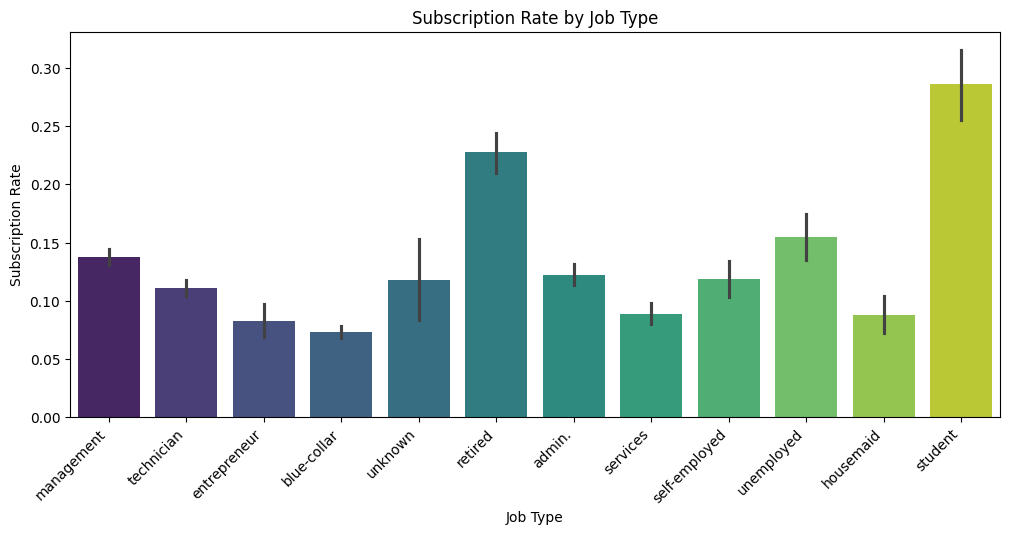

In [85]:
# Subscription Rate by Job Type
plt.figure(figsize=(12,5))
sns.barplot(x=df['job'], y=df['y'], palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Job Type")
plt.ylabel("Subscription Rate")
plt.title("Subscription Rate by Job Type")
plt.show()

### Subscription Rate by Job Type

This bar chart shows the **subscription rates** across different **job categories**. Among all groups, **students** have the highest subscription rate, exceeding **30%**, followed by **retired individuals** at around **25%**. These groups appear to be the most receptive to the marketing campaign. On the other hand, job types like **blue-collar**, **services**, and **entrepreneur** have the lowest subscription rates, typically under **10%**, indicating lower responsiveness. Other groups such as **admin**, **unemployed**, and **technician** fall in the middle range. Overall, the chart highlights that **job type could also be a strong predictor of subscription behavior**, and marketing efforts could be more effective if tailored toward high-response job categories.

## **2.3 Subscription Rate by Marital Status and Education Level**
We analyze how subscription rates vary across marital status and education levels, which are relevant for fairness considerations.


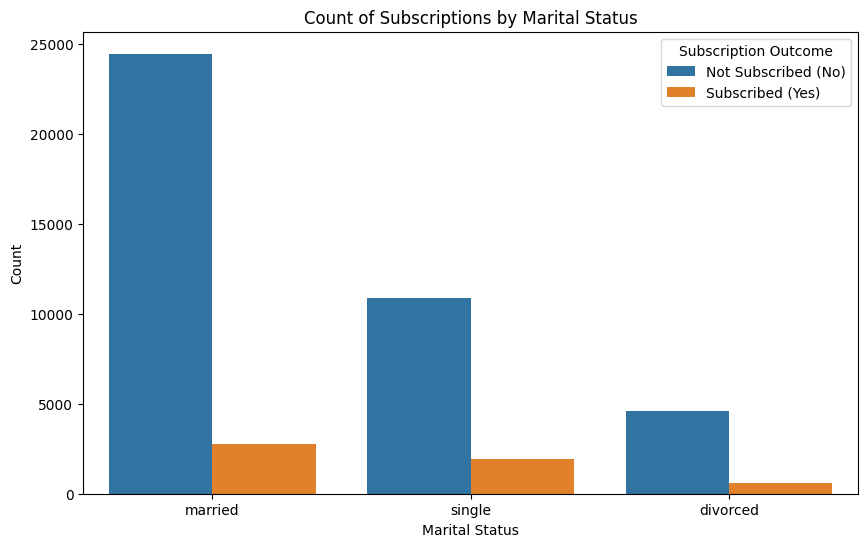

In [86]:
# Plot Count of Subscriptions by Marital Status
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='marital', hue='y', data=df)
plt.title('Count of Subscriptions by Marital Status')
plt.ylabel('Count')
plt.xlabel('Marital Status')

# Update legend labels
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['Not Subscribed (No)', 'Subscribed (Yes)'], title="Subscription Outcome")

plt.show()


## **Count of Subscriptions by Marital Status**
This graph shows the number of people who subscribed and didn’t subscribe to a service, based on their marital status. The x-axis represents different marital statuses: married, single, divorced, and unknown. The bars are color-coded, with blue showing people who did not subscribe and orange showing those who did. The graph clearly shows that most people, no matter their marital status, chose not to subscribe. Married people make up the largest group, followed by singles, then divorced individuals, and finally, a small number with an unknown status. Even though there are some subscribers in every group, the number of non-subscribers is much higher. This suggests that marital status might not have a big impact on whether someone subscribes, but married and single people seem slightly more likely to do so than divorced or unknown-status individuals.

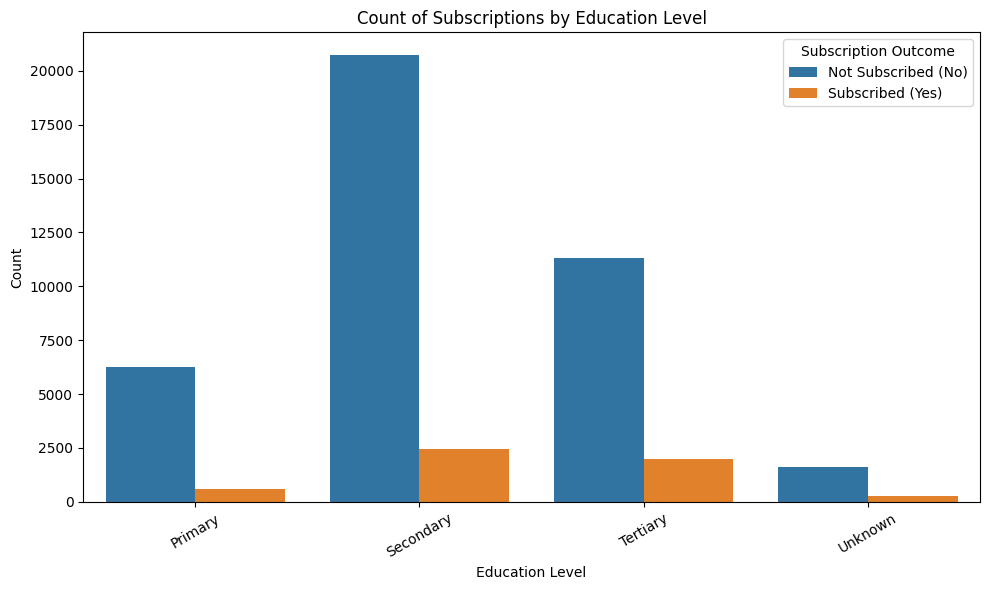

In [87]:
# Define a mapping for cleaner labels
education_labels = {
    "primary": "Primary",
    "secondary": "Secondary",
    "tertiary": "Tertiary",
    "unknown": "Unknown"
}

# Apply the mapping
df["education_clean"] = df["education"].replace(education_labels)

# Define a logical order for plotting
order = ["Primary", "Secondary", "Tertiary", "Unknown"]

# Plot the cleaned-up graph
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='education_clean', hue='y', data=df, order=order)
plt.title('Count of Subscriptions by Education Level')
plt.ylabel('Count')
plt.xlabel('Education Level')
plt.xticks(rotation=30)

# Update legend labels
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['Not Subscribed (No)', 'Subscribed (Yes)'], title="Subscription Outcome")

plt.tight_layout()
plt.show()


## **Count of Subscriptions by Education Level**  
This graph shows how subscription outcomes vary by education level. The x-axis includes four groups: Primary, Secondary, Tertiary, and Unknown. The blue bars represent individuals who did not subscribe, while the orange bars represent those who did. Most individuals, across all education levels, did not subscribe. However, the number of subscribers is noticeably higher among those with **tertiary** and **secondary** education compared to those with only **primary** education or **unknown** background. The **secondary education group** has the highest overall population, and also the highest number of subscribers in absolute terms. This suggests that education level may play a role in subscription behavior, with more educated individuals being slightly more likely to subscribe.

## **3. Fairness Metrics**

We will evaluate fairness using **three key metrics**: **demographic parity**, **true positive rate (TPR)**, and **false positive rate (FPR)**.  
- **Demographic parity** assesses whether the model gives equal positive predictions across different age groups, ensuring that no group is systematically favored or excluded.  
- **True positive rate (TPR)** measures how well the model correctly identifies actual subscribers. Comparing TPR across groups helps ensure that genuinely interested clients are equally likely to be recognized, reducing the risk of biased missed opportunities.  
- **False positive rate (FPR)** is also important, as it measures how often the model incorrectly predicts a subscription for someone who isn’t interested. If FPR is higher in one group, it could lead to inefficient marketing and potential customer dissatisfaction.  

Together, these metrics provide a well-rounded view of fairness, balancing **equal access**, **correct recognition of interest**, and **minimizing false targeting**.



## **3.1 Fairness Analysis (Age as Sensitive Attribute)**
We train a **Logistic Regression Classifier** and compute fairness metrics.


In [88]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Create a copy and label encode categorical columns
df_encoded = df.copy()
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                    'contact', 'month', 'poutcome']

for col in categorical_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# Define features and target
X = df_encoded.drop(columns=['y', 'age_group'])
y = df_encoded['y']

# Binary sensitive attribute: Z = 0 if Older (≥ 48), Z = 1 if Younger (< 48)
Z = df['age_group'].map({'Older (≥ 48)': 0, 'Younger (< 48)': 1})

# Train-test split with stratified sampling on the target
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(
    X, y, Z, test_size=0.2, random_state=42, stratify=y
)


In [89]:
# Train Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

import pandas as pd

# Convert categorical variables into dummy/indicator variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)


model = LogisticRegression(C=1, max_iter=1000, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))



Accuracy: 0.7988
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      7985
           1       0.35      0.81      0.48      1058

    accuracy                           0.80      9043
   macro avg       0.66      0.80      0.68      9043
weighted avg       0.90      0.80      0.83      9043




The model achieved an **overall accuracy of 79.8%**, driven largely by its strong performance on the majority class (non-subscribers). It shows a **high precision (0.97)** and **recall (0.80)** for class 0 (not subscribed), but while it captures a good number of actual subscribers (**recall = 0.81** for class 1), the **precision is low (0.35)**, meaning many predicted subscribers are false positives. This suggests the model is better at identifying non-subscribers and struggles with accurately identifying true subscribers.

In [90]:
# Compute Fairness Metrics for two age groups (0: Older, 1: Younger)
def compute_group_metrics(y_true, y_pred, group, Z):
    group_idx = (Z == group)
    y_true_group = y_true[group_idx]
    y_pred_group = y_pred[group_idx]
    
    tp = np.sum((y_pred_group == 1) & (y_true_group == 1))
    tn = np.sum((y_pred_group == 0) & (y_true_group == 0))
    fp = np.sum((y_pred_group == 1) & (y_true_group == 0))
    fn = np.sum((y_pred_group == 0) & (y_true_group == 1))

    total = len(y_true_group)
    positive_preds = np.sum(y_pred_group == 1)

    selection_rate = positive_preds / total if total > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Equal Opportunity
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    return {
        'Demographic Parity (Selection Rate)': selection_rate,
        'True Positive Rate (TPR)': tpr,
        'False Positive Rate (FPR)': fpr
    }

# Age group labels
age_group_names = {0: 'Older (≥ 48)', 1: 'Younger (< 48)'}

print("Fairness Analysis by Age Group:\n")
for group in [0, 1]:
    metrics = compute_group_metrics(y_test.values, y_pred, group, Z_test.values)
    print(f"Age Group: {group} ({age_group_names[group]})")
    for k, v in metrics.items():
        print(f" - {k}: {v:.4f}")
    print()


Fairness Analysis by Age Group:

Age Group: 0 (Older (≥ 48))
 - Demographic Parity (Selection Rate): 0.2646
 - True Positive Rate (TPR): 0.7851
 - False Positive Rate (FPR): 0.1840

Age Group: 1 (Younger (< 48))
 - Demographic Parity (Selection Rate): 0.2759
 - True Positive Rate (TPR): 0.8160
 - False Positive Rate (FPR): 0.2089




This fairness analysis shows how the model performs across the two age groups. The **Younger group** has a slightly higher **selection rate (27.59%)** than the **Older group (26.46%)**, meaning the model is marginally more likely to predict “subscribed” for younger individuals. The **true positive rate (TPR)** is also higher for the younger group (**81.60% vs. 78.51%**), indicating the model is better at correctly identifying actual subscribers in that group. However, the **false positive rate (FPR)** is also higher for the younger group (**20.89% vs. 18.40%**), meaning it makes more incorrect positive predictions for younger clients. Overall, the model performs comparably across both age groups, with a slight trade-off: improved subscriber detection for younger individuals comes with a small increase in false positives.

## **3.2 Fairness Analysis (Job Type as Sensitive Attribute)**
We repeat the analysis by setting job type as the sensitive attribute.


In [91]:
from sklearn.preprocessing import LabelEncoder

# Get original job titles before encoding
original_jobs = df['job'].copy()

# Create label encoder and fit on original job titles
le_job = LabelEncoder()
le_job.fit(original_jobs)

# Apply encoding to df_encoded for training
df_encoded['job'] = le_job.transform(df['job'])

# Prepare features
X = df_encoded.drop(columns=['y', 'job'])
y = df_encoded['y']
Z = df_encoded['job']  # Encoded job for fairness

# Train-test split
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(
    X, y, Z, test_size=0.2, random_state=42, stratify=y
)


In [92]:
# Train Model
# Convert categorical columns to numeric using one-hot encoding
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Ensure both train and test sets have the same features after encoding
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))


Accuracy: 0.8013
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      7985
           1       0.35      0.82      0.49      1058

    accuracy                           0.80      9043
   macro avg       0.66      0.81      0.68      9043
weighted avg       0.90      0.80      0.83      9043




The model achieves an **overall accuracy of 80.13%**, driven primarily by its strong performance on the majority class (`not subscribed`). It shows **high precision (0.97)** and **recall (0.80)** for this class, meaning it correctly identifies most non-subscribers and rarely misclassifies them. For the minority class (`subscribed`), the model demonstrates a **recall of 0.82**, indicating it correctly captures many actual subscribers. However, the **precision is low (0.35)**, meaning that a significant portion of predicted subscribers are actually non-subscribers. This imbalance highlights the model's tendency to generate more false positives in the minority class — a common issue when dealing with **class imbalance**.


In [93]:
# Compute Fairness Metrics by Job Title

def compute_job_group_metrics(y_true, y_pred, Z, job_num):
    group_idx = (Z == job_num)
    y_true_group = y_true[group_idx]
    y_pred_group = y_pred[group_idx]
    
    tp = np.sum((y_pred_group == 1) & (y_true_group == 1))
    tn = np.sum((y_pred_group == 0) & (y_true_group == 0))
    fp = np.sum((y_pred_group == 1) & (y_true_group == 0))
    fn = np.sum((y_pred_group == 0) & (y_true_group == 1))

    total = len(y_true_group)
    selection_rate = np.mean(y_pred_group) if total > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    return selection_rate, tpr, fpr

print("\nFairness Analysis by Job Title:\n")

for job_num in sorted(Z_test.unique()):
    job_title = le_job.inverse_transform([job_num])[0]
    sel_rate, tpr, fpr = compute_job_group_metrics(y_test.values, y_pred, Z_test.values, job_num)
    
    print(f"Job Title: {job_title}")
    print(f" - Demographic Parity (Selection Rate): {sel_rate:.4f}")
    print(f" - True Positive Rate (TPR): {tpr:.4f}")
    print(f" - False Positive Rate (FPR): {fpr:.4f}\n")



Fairness Analysis by Job Title:

Job Title: admin.
 - Demographic Parity (Selection Rate): 0.2272
 - True Positive Rate (TPR): 0.7541
 - False Positive Rate (FPR): 0.1564

Job Title: blue-collar
 - Demographic Parity (Selection Rate): 0.1977
 - True Positive Rate (TPR): 0.8175
 - False Positive Rate (FPR): 0.1496

Job Title: entrepreneur
 - Demographic Parity (Selection Rate): 0.2193
 - True Positive Rate (TPR): 0.7273
 - False Positive Rate (FPR): 0.1792

Job Title: housemaid
 - Demographic Parity (Selection Rate): 0.2379
 - True Positive Rate (TPR): 0.8750
 - False Positive Rate (FPR): 0.1626

Job Title: management
 - Demographic Parity (Selection Rate): 0.3405
 - True Positive Rate (TPR): 0.8385
 - False Positive Rate (FPR): 0.2638

Job Title: retired
 - Demographic Parity (Selection Rate): 0.4027
 - True Positive Rate (TPR): 0.8400
 - False Positive Rate (FPR): 0.2784

Job Title: self-employed
 - Demographic Parity (Selection Rate): 0.3065
 - True Positive Rate (TPR): 0.8889
 - Fa


These results highlight how the model's predictions differ across job categories in terms of fairness. **Selection rates** (demographic parity) vary across roles, ranging from **19.98%** for *blue-collar* workers to over **34%** for *management*, suggesting that individuals in some job types are more frequently predicted as subscribers than others. The **true positive rates (TPR)** are generally strong, with *housemaids* reaching the highest TPR at **87.50%**, followed by *blue-collar* and *management* roles. In contrast, *entrepreneurs* and *admin.* workers show lower TPRs around **72–73%**, meaning the model is less effective at identifying actual subscribers in those categories. **False positive rates (FPR)** also vary: while *housemaids* and *blue-collar* workers have relatively low FPRs (~15%), *entrepreneurs* have a higher rate of **18.28%**, indicating more incorrect positive predictions. These disparities suggest that the model performs unevenly across occupations, raising potential fairness concerns where certain job groups may be under- or over-predicted as likely subscribers.

## **3.3 Fairness Analysis (Education Level as Sensitive Attribute)**
We repeat the analysis by setting Education Level as the sensitive attribute.


In [94]:
# Encode Education Levels as Sensitive Attribute
education_mapping = {
    'primary': 0,
    'secondary': 1,
    'tertiary': 2,
    'unknown': 3
}

# Encode education as sensitive attribute
df_encoded['education_group'] = df['education'].map(education_mapping)
Z_edu = df_encoded['education_group']

# Prepare features and target
X = df_encoded.drop(columns=['y', 'education_group'])  # exclude sensitive attr
y = df_encoded['y']

# Drop rows with NaNs in target or sensitive attribute (safety step)
mask = (~y.isna()) & (~Z_edu.isna())
X = X[mask]
y = y[mask]
Z_edu = Z_edu[mask]

In [96]:
# Train-test split
X_train, X_test, y_train, y_test, Z_train_edu, Z_test_edu = train_test_split(
    X, y, Z_edu, test_size=0.2, random_state=42, stratify=y
)

# One-hot encode categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align train and test sets to have same columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Train logistic regression model
model = LogisticRegression(C=1, max_iter=1000, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print Accuracy and Classification Report
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.7979
              precision    recall  f1-score   support

           0       0.97      0.80      0.87      7985
           1       0.35      0.81      0.48      1058

    accuracy                           0.80      9043
   macro avg       0.66      0.80      0.68      9043
weighted avg       0.90      0.80      0.83      9043




The model achieves an **accuracy of 79.79%**, indicating that it correctly predicts subscription outcomes in most cases. It performs strongly on the majority class (`not subscribed`), achieving a **precision of 0.97** and **recall of 0.80**, meaning it correctly identifies most non-subscribers with very few false positives. For the minority class (`subscribed`), the model shows a **recall of 0.81**, capturing the majority of actual subscribers. However, the **precision is low at 0.35**, which means a large portion of predicted subscribers are false positives. This imbalance suggests that while the model is effective at finding actual subscribers, it tends to overpredict them—potentially leading to inefficient outreach in marketing applications.

In [97]:
def compute_fairness_metrics(y_true, y_pred, group):
    group_idx = (Z_test_edu == group)
    y_true_group = y_true[group_idx]
    y_pred_group = y_pred[group_idx]
    
    tp = np.sum((y_pred_group == 1) & (y_true_group == 1))
    tn = np.sum((y_pred_group == 0) & (y_true_group == 0))
    fp = np.sum((y_pred_group == 1) & (y_true_group == 0))
    fn = np.sum((y_pred_group == 0) & (y_true_group == 1))

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    selection_rate = np.mean(y_pred_group) if len(y_pred_group) > 0 else 0

    return selection_rate, tpr, fpr

# Compute and display fairness metrics
inverse_edu_mapping = {v: k.capitalize() for k, v in education_mapping.items()}

print("\nFairness Analysis by Education Level:")
for code in sorted(Z_test_edu.dropna().unique()):
    label = inverse_edu_mapping.get(code, "Unknown")
    sel_rate, tpr, fpr = compute_fairness_metrics(y_test.values, y_pred, code)
    print(f"Education Level: {label}")
    print(f" - Demographic Parity (Selection Rate): {sel_rate:.4f}")
    print(f" - True Positive Rate (TPR): {tpr:.4f}")
    print(f" - False Positive Rate (FPR): {fpr:.4f}\n")


Fairness Analysis by Education Level:
Education Level: Primary
 - Demographic Parity (Selection Rate): 0.2144
 - True Positive Rate (TPR): 0.8509
 - False Positive Rate (FPR): 0.1542

Education Level: Secondary
 - Demographic Parity (Selection Rate): 0.2338
 - True Positive Rate (TPR): 0.7612
 - False Positive Rate (FPR): 0.1745

Education Level: Tertiary
 - Demographic Parity (Selection Rate): 0.3628
 - True Positive Rate (TPR): 0.8449
 - False Positive Rate (FPR): 0.2745

Education Level: Unknown
 - Demographic Parity (Selection Rate): 0.3573
 - True Positive Rate (TPR): 0.8750
 - False Positive Rate (FPR): 0.2665



This analysis evaluates fairness across different education levels by comparing **demographic parity** (selection rate), **true positive rate (TPR)**, and **false positive rate (FPR)**. Individuals with **tertiary** and **unknown** education levels have the **highest selection rates** (36.28% and 35.73%, respectively), suggesting the model is more likely to predict subscriptions for these groups. Both groups also show high TPRs (above 84%), meaning they are effectively identified when they truly are subscribers. However, they also exhibit **higher false positive rates** (around 27%), indicating more incorrect positive predictions. In contrast, individuals with **primary** and **secondary** education have **lower selection rates** (21–23%) and slightly lower TPRs, with **secondary** education showing the lowest TPR at 76.12%. These results indicate that while the model is more aggressive in predicting subscriptions for highly educated or unknown-background individuals, it does so at the cost of higher false positives—raising fairness concerns around over-targeting certain education groups.

Here’s a revised version of your **Discussion** section based on the actual results you've shared so far:

---

## **4. Discussion**

After training, we observed an overall **accuracy of ~80%** and evaluated fairness metrics across three sensitive attributes: **Age Group**, **Job Type**, and **Education Level**.

### **4.1 Overall Performance**

- **Accuracy:**  
  - **Age Group as Sensitive Attribute:** **79.88%**  
  - **Job Type as Sensitive Attribute:** **80.13%**  
  - **Education Level as Sensitive Attribute:** **79.79%**

- **Precision & Recall for Class 1 (Subscribed):**  
  - **Precision:** ~35%  
  - **Recall:** ~81–82%

The model performs well in identifying non-subscribers (class 0), with high precision and recall. For the minority class (`subscribed`), recall is relatively strong (indicating the model successfully captures most actual subscribers), but **precision is low (~35%)**, meaning many predicted subscribers are incorrect. This reflects the challenge of **class imbalance**, where false positives are more frequent in the minority class.

---

### **4.4 Which Sensitive Attribute (z) Should We Focus On?**

Among the three sensitive attributes considered—**age group, job type, and education level**—**age** stands out as the most critical to focus on from both a legal and ethical standpoint. Age is a **legally protected characteristic**, and any systematic disadvantage toward a particular age group can raise serious compliance and fairness concerns. Our analysis revealed consistent disparities between age groups, with the model showing differing behavior in how it predicts outcomes for older versus younger individuals. Even when these differences are subtle, they can lead to disproportionate targeting or exclusion in real-world applications.

### **Sensitive Attribute (z) is age.**

We chose age as our sensitive attribute because age correlates with differing financial behaviors and needs. For example, younger individuals typically require more liquidity and are less likely to commit to long-term savings products like bank term deposits due to their dynamic financial circumstances and greater likelihood of needing immediate access to cash. On the other hand, older individuals often have more financial stability and may be more inclined to lock in funds for a higher return. Additionally, many of the other features such as marital status, job type, if the customer has a housing loan or not, and much more are correlated to age.

This naturally creates a potential for unfairness where models trained on historical data might inadvertently favor older clients while neglecting younger ones—even if the underlying behavior differences are statistically true on average. By focusing on age, we can analyze and quantify these disparities (e.g., through differences in true positive rates) and then apply fairness interventions to ensure that the model does not systematically disadvantage younger clients, making our results both interesting and practically relevant.

### **Discussion: Discuss which fairness metrics are specifically relevant to your task - Equal Opportunity**
We chose equal opportunity as our primary fairness metric because it directly measures the model's ability to correctly identify positive cases (i.e., clients who subscribe to a term deposit) across different groups. From the perspective of the bank, we want to get as many customers to subscribe to a term deposit as possible. If a person would be interested to a term deposit, we want to ensure that we speak to them to secure the deposit. In contrast, it's OK if this comes a little bit at a cost of an increase in failed calls. In terms of our model, we want to increase the true positive rate (TPR) of the underserved group to match the better-served group. Ideally, we achieve this with minimal loss in accuracy (to prevent wasted time or marketing efforts). Additionally, we would not want to discriminate against younger clients, since they would potentially be ones to subscribe for longer and simply just developing long-term relationships with them could result in more buisiness in the future.

In our context, ensuring that the TPR is as close as possible for both the better-served group (e.g., older clients) and the underserved group (younger clients) is critical for guaranteeing equal opportunity. A low TPR difference indicates that clients with a genuine likelihood to subscribe are equally recognized by the model, regardless of their age. This metric is particularly relevant because misclassifying a true positive (especially for a group that might already be under-targeted) can lead to missed opportunities and potential discrimination. Using a ratio of the TPRs allows us to quantify fairness in a way that addresses the core objective of our predictive task.

By focusing on the ratio of the TPRs, we ensure that both older (protected) and younger (unprotected) clients who are truly eligible for the product are equally likely to be identified by the model, which maximizes the effects of the marketing campaign. Our argument emphasizes that, given the potential consequences for customer access and fairness in financial services, using the ratio of TPRs or equal opportunity as our fairness metric is not only justified but essential for the responsible and successful deployment of the predictive model.

### **Data Preparation + Base Model**

We import the necessary libraries (pandas, NumPy, scikit-learn, etc.) and load our data `bank-full.csv`. For data pre-processing, we simply just converted all categorical data into one-hot-encodings and scaled numerical values for faster convergence. We then converts the label to binary indicating whether a client subscribed to a term deposit or not and then created the sensitive attribute z based on age. To create a binary variable and separate the "older" group from the "younger" group, we split on the 75th percentile ($z=0$ if $\text{age} \geq 48$, $z=1$ otherwise) The data is split into training and test sets. 

We used a logstic regression model as our baseline and define a helper function for calculating the True Positive Rate (TPR) to measure equal opportunity.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the data
data_path = "bank-full.csv"
df_original = pd.read_csv(data_path, sep=";")
df = df_original.copy()

# Obtain the 75th percentile of the age column to use as the threshold for the sensitive attribute
age_threshold = df["age"].quantile(0.75)
print("Age threshold:", age_threshold)

# Convert the target variable to binary (0 = No, 1 = Yes)
df["y"] = df["y"].apply(lambda x: 0 if x == "no" else 1)
# Convert the sensitive attribute to binary (z = 0 if age >= 48, z = 1 if age < 48)
df["z"] = df["age"].apply(lambda x: 0 if x >= age_threshold else 1)
# Drop the age column
df = df.drop(columns=["age"])

categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day", "poutcome"]
numerical_cols = ["duration", "campaign", "pdays", "previous", "balance"]
assert len(categorical_cols) + len(numerical_cols) + 2 == df.shape[1] # 2 = y and z

# Scale the numerical variables
for col in numerical_cols:
    scaler = StandardScaler()
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

# Encode the categorical variables to OHE
df = pd.get_dummies(df, columns=categorical_cols)

# Form X and y
X = df.drop(columns=["y"])
y = df["y"].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
# Print number of z=0 in total set
print("Number of older customers (z=0) in dataset:", df["z"].value_counts()[0])
print("Number of younger customers (z=1) in dataset:", df["z"].value_counts()[1])

Age threshold: 48.0
Train set size: 36168
Test set size: 9043
Number of older customers (z=0) in dataset: 12185
Number of younger customers (z=1) in dataset: 33026


In [19]:
# Helper function to compute performance metrics per group
def compute_group_rates(y_true, y_pred, Z_test, group):
    group_idx = (Z_test == group)
    tp = np.sum((y_true[group_idx] == 1) & (y_pred[group_idx] == 1))
    fp = np.sum((y_true[group_idx] == 0) & (y_pred[group_idx] == 1))
    tn = np.sum((y_true[group_idx] == 0) & (y_pred[group_idx] == 0))
    fn = np.sum((y_true[group_idx] == 1) & (y_pred[group_idx] == 0))
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    return tpr, fpr, tnr, fnr

# Train a logistic regression model
def baseline_model(X_train, y_train):
    model = LogisticRegression(C=1, max_iter=1000, class_weight="balanced", random_state=42)
    model.fit(X_train, y_train)
    return model

model = baseline_model(X_train, y_train)
y_pred = model.predict(X_test)

# Print the total accuracy
def print_performance_metrics(y_test, y_pred, X_test):
    acc = accuracy_score(y_test, y_pred)
    tpr = np.sum((y_test == 1) & (y_pred == 1)) / np.sum(y_test == 1)
    print(f"Model Accuracy: {acc}")
    print(f"Model Total TPR: {tpr}")
    # Print the performance metrics for each group
    tprs = []
    for group in [0, 1]:
        tpr, fpr, tnr, fnr = compute_group_rates(y_test, y_pred, X_test["z"].values, group)
        name = "Older" if group == 0 else "Younger"
        print(f"{name} - TPR: {tpr}, FPR: {fpr}, TNR: {tnr}, FNR: {fnr}")
        tprs.append(tpr)
    print(f"TPR Ratio: {tprs[0] / tprs[1]}")
    print(f"TPR Difference: {tprs[0] - tprs[1]}")

print_performance_metrics(y_test, y_pred, X_test)

Model Accuracy: 0.8439677098308084
Model Total TPR: 0.8350137488542622
Older - TPR: 0.8753894080996885, FPR: 0.18233618233618235, TNR: 0.8176638176638177, FNR: 0.12461059190031153
Younger - TPR: 0.8181818181818182, FPR: 0.14488539172083476, TNR: 0.8551146082791652, FNR: 0.18181818181818182
TPR Ratio: 1.0699203876773968
TPR Difference: 0.05720758991787023


### **Base Model - Results**

This code snippet defines a helper function, compute_group_rates, which calculates several performance metrics (TPR, FPR, TNR, and FNR) for a given subgroup in the test set based on the sensitive attribute Z. The function filters the test set based on whether the sensitive attribute matches the group value provided (in this case, 0 for the older group and 1 for the rest), and then computes the counts of true positives, false positives, true negatives, and false negatives to derive the metrics.

From our results, our model achieves an total accuracy of approximately 84.4%, meaning it correctly predicts whether clients will subscribe to a term deposit about 84% of the time. When we break down the performance by the sensitive attribute—age—the "Older" group (clients with age values indicating they belong to group 0) shows a True Positive Rate (TPR) of about 87.5%, while the "Younger" group (group 1) has a TPR of approximately 81.8%. This indicates that the model correctly identifies positive cases (i.e., actual subscriptions) more often in the older group than in the younger group. The absolute TPR difference is around 5.72%, which indicates the model predicts older clients that subscribed correctly around 5.72% more than younger clients. Additionally, the older group also has a higher False Positive Rate (FPR) and correspondingly lower False Negative Rate (FNR) compared to the younger group. These disparities highlight that the model exhibits a bias favoring the older group. 

### **Reasoning - Why we chose 'age'**

Since we chose to split on the 75th percentile of age, the younger category (clients under 48) is somewhat larger than the older category (clients 48 or above). From the baseline model, the older group obtains a TPR of 0.875 while the younger group obtains a TPR of 0.818, despite the younger group having 20841 more samples. Additionally, the FPR of the older group is higher than the younger group (0.182 vs 0.145). So, not only does the baseline model disproportionately predict the older group to subscribe correctly compared to the younger group, it also disproportionately predicts older people who did not end up subscribing as well. In general, it seems like the model is biased to predict older people as people who would subscribe to a term deposit regardless if they actually will in comparison to younger people.

In [100]:
# sns.countplot(x="z", data=df, palette="viridis", hue="z", legend=False)
# plt.title("Distribution of age groups (Older: Age >= 48, Younger: Age < 48)")
# plt.xlabel("Age group")
# plt.ylabel("Count")
# plt.xticks([0, 1], ["Older", "Younger"])
# plt.show()

In [99]:
# # Counts of old vs young people who subscribed to the term deposit
# older_people_subscribed = df[(df["z"] == 0) & (df["y"] == 1)].shape[0]
# younger_people_subscribed = df[(df["z"] == 1) & (df["y"] == 1)].shape[0]
# print(f"Percentage of subscribers that are older: {older_people_subscribed / (older_people_subscribed + younger_people_subscribed) * 100}")
# print(f"Percentage of subscribers that are younger: {younger_people_subscribed / (older_people_subscribed + younger_people_subscribed) * 100}")
# plt.bar(["Older", "Younger"], [older_people_subscribed, younger_people_subscribed], color="skyblue")
# plt.title("Number of people who subscribed to the term deposit")
# plt.xlabel("Age group")
# plt.ylabel("Count")
# plt.show()


In [98]:
# # Ratio of people who subscribed to the term deposit by group
# # Older people
# older_subscribed = df[(df["z"] == 0) & (df["y"] == 1)].shape[0]
# older_total = df[df["z"] == 0].shape[0]
# older_ratio = older_subscribed / older_total
# # Younger people
# younger_subscribed = df[(df["z"] == 1) & (df["y"] == 1)].shape[0]
# younger_total = df[df["z"] == 1].shape[0]
# younger_ratio = younger_subscribed / younger_total
# # Plot
# plt.bar(["Older", "Younger"], [older_ratio, younger_ratio], color="skyblue")
# plt.title("Ratio of people who subscribed to the term deposit by group")
# plt.xlabel("Age group")
# plt.ylabel("Ratio")
# plt.show()


## **Interventions**
### **How much can "unfairness" in your predictions be explained by dataset characteristics? Can you fix them with dataset-based interventions?**

The unfairness in the predictions can be explained by dataset characteristics. Firstly, there are many more people who are "younger" ($z=1$) in our dataset compared to older since we chose age by the dividing the groups on the 75th percentile of the dataset. Looking at the counts of people who subscribed, around 30% of people who subscribed ($y=1$) were "older" ($z=0$) and 70% of people who subscribed were "younger" ($z=1$). This is relatively close to the ratio of the groups as a whole. However, if we compared the percentage of older people that subscribed among all older people, it is slightly higher (around 13%) compared to younger people (around 11%). These ratios are quite close, but the data says that older people might be slightly more likely to subscribe compareed to younger people.

So, we attempt to address this with a simple dataset-based intervention. Because we are using equal opportunity as our metric of fairness, we are mostly concerned with improving the TPR of the underserved group ($z=1$). So, we add duplicate samples of data points where $z=1$ and $y=1$.

First, we just copy the original dataset, then find the number of datapoints where $z=1$ and $y=1$ times some coefficient labeled `boost_rate`. Then, we simply add $(\text{boost\_rate} - 1.0) * |D_{z=1, y=1}|$ duplicate samples of data where $z=1$ and $y=1$ back into the dataset. All other groups stay the same. Then, we just train our baseline classifier using this new resampled dataset.

In [23]:
def resample_data(X_train, y_train, boost_rate):
    # Oversample number of samples (z=1, y=1) by the boost_rate
    X_train_resampled = X_train.copy().to_numpy()
    y_train_resampled = y_train.copy()
    # Get the indices of the samples with z=1 and y=1
    z1_y1_indices = np.where((X_train["z"] == 1) & (y_train == 1))[0]
    num_z1_y1 = len(z1_y1_indices)

    # Oversample the positive, underserved group
    num_to_sample = int((boost_rate-1.0) * num_z1_y1)
    # Sample uniformly
    np.random.seed(42)
    sampled_positive_minority = np.random.choice(z1_y1_indices, num_to_sample, replace=True)

    # Append the resampled data to the original data
    X_train_resampled = np.vstack((X_train_resampled, X_train.iloc[sampled_positive_minority].to_numpy()))
    y_train_resampled = np.hstack((y_train_resampled, y_train[sampled_positive_minority]))
    return X_train_resampled, y_train_resampled

X_train_resampled, y_train_resampled = resample_data(X_train, y_train, boost_rate=1.25)
print("Train set size before resampling:", X_train.shape[0])
print("Train set size after resampling:", X_train_resampled.shape[0])

# Train a logistic regression model on the resampled data
model_resampled = baseline_model(X_train_resampled, y_train_resampled)
y_pred_resampled = model_resampled.predict(X_test.to_numpy())
print_performance_metrics(y_test, y_pred_resampled, X_test)

Train set size before resampling: 36168
Train set size after resampling: 36905
Model Accuracy: 0.8431936304323786
Model Total TPR: 0.8313473877176902
Older - TPR: 0.8504672897196262, FPR: 0.16619183285849953, TNR: 0.8338081671415005, FNR: 0.14953271028037382
Younger - TPR: 0.8233766233766234, FPR: 0.1512145056448854, TNR: 0.8487854943551146, FNR: 0.17662337662337663
TPR Ratio: 1.0329019133818802
TPR Difference: 0.027090666343002723


### Dataset-Based Intervention Results

By resampling our dataset, we were able to maintain the same accuracy of ~84%, but were able to improve the overall fairness since the difference in TPRs was 5.7% in the baseline model down to 2.7% if we use the dataset based intervention. While this improves the fairness, there is still a tradeoff in overall performance. The TPR for the $z=0$ group went down from ~87.5% to ~85%, but the TPR for the $z=1$ group improves from ~81.8% to ~82.3%. So, with this technique and parameter set-up, it is important to understand that we tradeoff performance for the $z=0$ group in order to boost the $z=1$ group.

### **How do different modeling choices impact fairness characteristics? Can you fix them with in-processing interventions?**
Different modeling choices can impact fairness characteristics. The model architecture and optimization algorithms themselves can play a big role in the fairness (or unfairness) of the model. The model we chose was a simple logistic regression model, which tries to optimize some parameters by minimizing the log loss function. This minimizes the mean of the negative log-likelihoods. The dataset and optimization process chosen could guide the model toward some optimum that is unfair to the $z=1$ group in comparison to the $z=0$ group.

To mitigate this through model-based or inprocessing interventions, we applied a higher sample weight to each datapoint that was of the group ($z=1$ and $y=1$). Through the optimization process, it takes the training examples where the person is of the "older" group and subscribed to a term deposit and weights them larger in the overall cost function. Below, we simply just attached a larger weight of 1.25 to the ($z=1$ and $y=1$) group and left the sample weight of all other examples as 1.0. Then, we just provide the weights to the library function to weigh each respective example during training. We again use a LogisticRegression model optimized with these new sample weights.

In [24]:
def p3model(X_train, y_train):
    sample_weights = []
    for i, (_, row) in enumerate(X_train.iterrows()):
        z = row["z"]
        y = y_train[i]
        if z == 1 and y == 1:
            sample_weights.append(1.25)
        else:
            sample_weights.append(1.0)
    
    model = baseline_model(X_train, y_train)
    model.fit(X_train, y_train, sample_weight=sample_weights)
    return model

model = p3model(X_train, y_train)
y_pred = model.predict(X_test)

# Print the performance metrics
print_performance_metrics(y_test, y_pred, X_test)

Model Accuracy: 0.8306977772862988
Model Total TPR: 0.8551787351054079
Older - TPR: 0.8753894080996885, FPR: 0.18233618233618235, TNR: 0.8176638176638177, FNR: 0.12461059190031153
Younger - TPR: 0.8467532467532467, FPR: 0.16917550461854258, TNR: 0.8308244953814574, FNR: 0.15324675324675324
TPR Ratio: 1.0338187795042333
TPR Difference: 0.028636161346441757


### Model-Based Intervention Results
Looking at the results of the model-based intervention, we can see that the total accuracy goes down from 84.3% to 83%. However, the TPR for the $z=0$ group stays the same and the TPR for the $z=1$ group goes up from ~81.8% to 84.6% and has a TPR difference of 2.9% from 5.7%. This is better in terms of fairness and in the context of maximizing subscribers compared to the baseline. This is one of the more ideal results, as we improve the TPR of the younger group, without decreasing the TPR of the older group -- improving the fairness of the model without causing the TPR of the better-served group to suffer.

The tradeoff here is that the total accuracy goes down (as a result of more false positives). This could result in more failed calls, which would not be good if the main constraint in the marketing campaign is the amount of time you can spend speaking to customers.

### **Can you apply post-processing interventions to achieve desired fairness outcomes?**

There are a couple of ways we can try to apply post-processing interventions to improve fairness. First, we can try adjusting the decision threshold for all classes that maximizes TPR for both groups by plotting the ROC curve for each and finding the interesection. Below, we wrote a function that allows you to adjust the thresholds for both classes (1 threshold) or each class individually (2 thresholds). Below, we compute the ROC curves for each group and find an intersection that maximizes TPR with minimal loss in training accuracy.

Below, we simply use the trained baseline model to produce probabilities, and then adjust a single threshold. If the probability is greater than the threshold, we choose the label to be 1. By adjusting the thresholds, we can try to improve the fairness.

Threshold: 0.4152613858188782 -- TPR: 0.8853247794707297, FPR: 0.2043238162378099


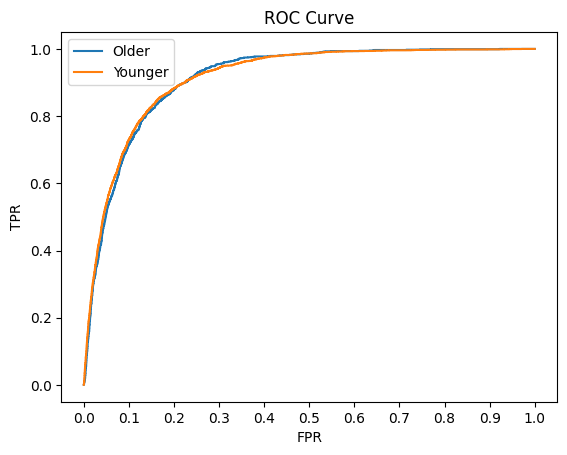

In [25]:
def p4predict(X, threshold):
    probs = model.predict_proba(X)[:, 1]
    predictions = []
    if isinstance(threshold, list):
        t0, t1 = threshold
        for prob in probs:
            if X["z"].values[i] == 0:
                if prob >= t0:
                    predictions.append(1)
                else:
                    predictions.append(0)
            else:
                if prob >= t1:
                    predictions.append(1)
                else:
                    predictions.append(0)
    else:
        for prob in probs:
            if prob >= threshold:
                predictions.append(1)
            else:
                predictions.append(0)
    return np.array(predictions)

# First, need to find the optimal threshold for the model
model = baseline_model(X_train, y_train)
probs = model.predict_proba(X_train)[:, 1]

# Obtain the ROC curves for each group
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
fpr0, tpr0, thresholds0 = roc_curve(y_train[X_train["z"] == 0], probs[X_train["z"] == 0])
fpr1, tpr1, thresholds1 = roc_curve(y_train[X_train["z"] == 1], probs[X_train["z"] == 1])

from scipy.interpolate import interp1d
f1 = interp1d(fpr1, tpr1)
tpr1_interp = f1(fpr0)

# Find last intersection
threshold = 0.001
indices = []
for i in range(len(tpr0)):
    if tpr0[i] < 0.1: # TPR should be at least 0.8 and less than 0.9
        continue

    if abs(tpr0[i] - tpr1_interp[i]) <= threshold:
        indices.append(i)

# Find the intersection with the highest TPR
best_threshold = thresholds0[indices[0]]
print(f"Threshold: {best_threshold} -- TPR: {tpr0[indices[0]]}, FPR: {fpr0[indices[0]]}")

# Plot the ROC curves
plt.plot(fpr0, tpr0, label="Older")
plt.plot(fpr1, tpr1, label="Younger")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xticks(np.linspace(0, 1, 11))
plt.title("ROC Curve")
plt.legend()

As we can see from the ROC Curve, there is an intersection at around the $\text{FPR} = 0.204$, $\text{TPR} = 0.885$ point on the graph, which corresponds to a threshold of $0.415$. So, we can adjust our decision threshold to this and check our results.

In [26]:
# Compute probablilites and predict based on the new threshold
y_pred = p4predict(X_test, best_threshold)

# Print the performance metrics
print_performance_metrics(y_test, y_pred, X_test)

Model Accuracy: 0.8128939511224151
Model Total TPR: 0.8771769019248395
Older - TPR: 0.9158878504672897, FPR: 0.2198480531813865, TNR: 0.7801519468186134, FNR: 0.08411214953271028
Younger - TPR: 0.861038961038961, FPR: 0.18730756072528223, TNR: 0.8126924392747178, FNR: 0.13896103896103895
TPR Ratio: 1.0637008218096728
TPR Difference: 0.05484888942832866


Using just a single threshold, we observe that the overall accuracy decreased slightly to 81.3% from 84.4%. However, the intervention resulted in a True Positive Rate (TPR) of 91.6% for older clients and 86.1% for younger clients, leading to a TPR difference of 5.4 percentage points. The total TPR increased to 87.7% from 83.5% as well. This intervention however, does not improve the disparity in TPRs between the group much, so we went on to try a different approach. Below, we implemented a different decision threshold for each group and found two thresholds minimized the difference between the TPRs for each group, while maintained some level of total accuracy.

In [27]:
# Try two different thresholds (one for z=0, one for z=1)
# Maintain total training accuracy (do not lower it to less than 80%)

# Loop over different combinations of thresholds
# Find the one with the smallest TPR difference (without lowering training accuracy to less than 80%)
best_acc = 0.0
best_diff = np.inf
best_t0, best_t1 = None, None
for t0 in tqdm(np.linspace(0.35, 0.65, 25)): # Constrain the thresholds slightly
    for t1 in np.linspace(0.35, 0.65, 25):
        # Compute scores and predict based on each threshold
        preds = p4predict(X_train, [t0, t1])

        # Compute accuracy and TPRs
        acc = accuracy_score(y_train, preds)
        tpr0, _, _, _ = compute_group_rates(y_train, preds, X_train["z"].values, 0)
        tpr1, _, _, _ = compute_group_rates(y_train, preds, X_train["z"].values, 1)
        diff = abs(tpr0 - tpr1)

        # Update the best thresholds if the conditions are met
        if acc >= 0.8 and diff < best_diff:
            best_diff = diff
            best_acc = acc
            best_t0 = t0
            best_t1 = t1

print(f"Best Thresholds: z=0: {best_t0}, z=1: {best_t1}")
print(f"Best Training Accuracy: {best_acc}")
print(f"Best TPR Difference: {best_diff}")

100%|██████████| 25/25 [01:28<00:00,  3.53s/it]

Best Thresholds: z=0: 0.45, z=1: 0.35
Best Training Accuracy: 0.83076199955762
Best TPR Difference: 0.008584207655812137


In [28]:
# Now, just use the best thresholds to predict and compute the performance metrics on the test set
y_pred = p4predict(X_test, [best_t0, best_t1])

# Print the performance metrics
print_performance_metrics(y_test, y_pred, X_test)

Model Accuracy: 0.778281543735486
Model Total TPR: 0.9074243813015582
Older - TPR: 0.940809968847352, FPR: 0.26495726495726496, TNR: 0.7350427350427351, FNR: 0.059190031152647975
Younger - TPR: 0.8935064935064935, FPR: 0.23024290112897708, TNR: 0.769757098871023, FNR: 0.10649350649350649
TPR Ratio: 1.0529413895529958
TPR Difference: 0.04730347534085855


### Post-Processing Intervention - Results
The results of using two thresholds gives us a TPR difference of 4.7%. This improves upon the baseline and the minor improvement that modifying a single threshold for both classes gave. However, as a tradeoff, we reduced the testing accuracy to 77.8% -- a 6.6% decrease in accuracy. So, this type of post-processing intervention doesn't quite improve the fairness as much as the previous interventions.

Looking at the results as a whole, we can see that utilizing different thresholds for each groups helps to improve the fairness (equal opportunity of our model) overall. This would help to improve the overall number of people who submit term deposits, especially in comparison to using a single threshold. However, it comes at a cost in lowering the model accuracy. The FPRs increase as well as an effect, which means we likely would result more failed calls than if you just used the baseline model.

So, finetuning the thresholds alone as a post-processing interevention probably isn't the best method to improve the fairness of the model as the improved amount of fairness probably isn't worth the decrease in overall performance of the model in this case. Combined with other interventions like the model-based interventions, it could still be helpful.

### **What types of interventions are most appropriate for your task? What are the tradeoffs between them?**

For this task, all interventions could be realistic to implement. There are aren't any constraints that would prevent the bank from implementing a pre-processing, in-processing, or post-processing model. So, the choice of intervention should look mostly at the results of each intervention and decide which tradeoffs you want to take. Assuming you only applied one intervention:

- The pre-processing intervention did a good job of decreasing the gap in TPRs between the two groups while maintaining accuracy. The tradeoff with them was that we decrease the number of correctly predicted examples from the older ($z=0$) group.
- The in-processing intervention did a very similar job as the pre-processing intervention, but did not decrease the TPR of the older group, just increased the TPR of the younger group.
- The post-processing intervention did the best at increasing the TPRs, but did worse in terms of fairness compared to the other interventions and greatly increased the FPRs for both groups and total accuracy as a result. This would result in more potentially wasted time in calls that do not result in a term deposit subscriber.

So, if you had to only choose one intervention, in-processing probably improves the fairness the best while maintaining the other performance metrics like total accuracy. However, it doesn't necessarily mean that only one intervention is required. Combining both in-processing and post-processing could result in an even better result that improves fairness even more, while maintaining minimial loss in total accuracy.

## **Paper**

### **Summarize the main contributions of the paper and its relevance to your task.**

The paper by Kamiran and Calders (2012) introduces several data preprocessing techniques aimed at addressing discrimination in classification tasks. The key contributions of this work include methods such as Massaging, Reweighing, and Sampling (both Uniform and Preferential Sampling). These techniques are specifically designed to adjust biased datasets in ways that significantly reduce discrimination while maintaining predictive accuracy.

Among these methods, Preferential Sampling (PS) stands out as particularly effective. Preferential Sampling prioritizes modifying data instances that lie near the decision boundary, as these instances are more likely to influence the classifier's fairness. By selectively duplicating or removing data points closest to the decision boundary, PS achieves a more targeted reduction of discrimination compared to Uniform Sampling, which randomly samples data points.

In Preferential Sampling (PS), data objects close to the decision boundary are identified as more susceptible to discriminatory outcomes. To identify these borderline instances, PS begins by learning a ranker from the training data, sorting data objects from DP (deprived-positive) and FP (favored-positive) groups in ascending order, and those from DN (deprived-negative) and FN (favored-negative) groups in descending order with respect to their positive class probability. This ranking ensures that elements at the top of the list are closest to the decision boundary. PS then iteratively duplicates instances closest to the boundary from the DP and FN groups to increase their representation, and removes instances closest to the boundary from the DN and FP groups to decrease their representation, achieving balanced groups.

### **Code - Summary**

In our implementation, we merged the original feature set (X_train) and labels (y_train) into a single DataFrame, facilitating joint analysis of sensitive group membership (z) and class labels (y). Next, the algorithm calculates specific sampling weights for each subgroup defined by combinations of the sensitive attribute (z) and class label (y). These weights determine how the dataset will be resampled to correct existing imbalances, ideally enhancing model fairness. After computing these weights, the code trains a baseline predictive model on the original dataset to obtain a score (probability) for each instance, indicating how confidently the model predicts the positive class. Using these scores, the dataset is partitioned into four distinct subsets according to sensitive group membership and class label combinations. The resampling process then selectively includes instances from each subgroup, prioritizing higher- or lower-ranked samples as dictated by the computed weights. Positive instances from the sensitive group (z=1) and negative instances from the non-sensitive group (z=0) are oversampled, while other subsets are adjusted accordingly, resulting in a preferentially sampled dataset (D_PS) intended to counteract bias. At the end, this preferentially sampled dataset is returned, separated back into feature and label arrays, ready for fairer downstream model training. We successfuly reproduced the code and results in similar results to those reported in the paper.

In [29]:
def preferential_sampling(X_train, y_train):
    # Combine the dfs
    df = X_train.copy()
    df["y"] = y_train

    weights = {
        (0, 0): 1.0,
        (0, 1): 1.0,
        (1, 0): 1.0,
        (1, 1): 1.0
    }
    for s in [0, 1]: # Loop over the groups
        for c in [0, 1]: # Loop over the classes
            numer1 = len(df[df["z"] == s])
            numer2 = len(df[df["y"] == c])
            denom1 = len(df)
            denom2 = len(df[(df["z"] == s) & (df["y"] == c)])
            weights[(s, c)] = (numer1 * numer2) / (denom1 * denom2)

    # Learn a ranker R for predicting the + using D as the training set
    R = baseline_model(df.drop(columns=["y"]), df["y"])
    scores = R.predict_proba(X_train)[:, 1]
    df["score"] = scores

    DP = df[(df["z"] == 1) & (df["y"] == 1)] # {X in D | X(S) = 1 ^ X(Class) = +}
    DN = df[(df["z"] == 1) & (df["y"] == 0)] # {X in D | X(S) = 1 ^ X(Class) = -}
    FP = df[(df["z"] == 0) & (df["y"] == 1)] # {X in D | X(S) = 0 ^ X(Class) = +}
    FN = df[(df["z"] == 0) & (df["y"] == 0)] # {X in D | X(S) = 0 ^ X(Class) = -}
    
    D_PS = pd.DataFrame(columns=df.columns).astype(df.dtypes)
    # Add floor(W(1, 1)) copies of DP to D_PS
    num_dp = int(weights[(1, 1)])
    for _ in range(num_dp):
        D_PS = pd.concat(
            [
                D_PS,
                DP
            ],
            ignore_index=True
        )

    # Add floor(W(1, 1) - (floor(W(1,1)) * |DP|)) lowest ranked elements from DP to D_PS
    num_dp = int(weights[(1, 1)] - (int(weights[(1, 1)]) * len(DP)))
    D_PS = pd.concat(
        [
            D_PS,
            DP.nsmallest(num_dp, "score")
        ],
        ignore_index=True
    )

    # Add floor(W(1, 0) * |DN|) lowest ranked elements from DN to D_PS
    num_dn = int(weights[(1, 0)] * len(DN))
    D_PS = pd.concat(
        [
            D_PS,
            DN.nsmallest(num_dn, "score")
        ],
        ignore_index=True
    )

    # Add floor(W(0, 1) * |FP|) highest ranked elements from FP to D_PS
    num_fp = int(weights[(0, 1)] * len(FP))
    D_PS = pd.concat(
        [
            D_PS,
            FP.nlargest(num_fp, "score")
        ],
        ignore_index=True
    )
    
    # Add floor(W(0, 0)) copies of FN to D_PS
    num_fn = int(weights[(0, 0)])
    for _ in range(num_fn):
        D_PS = pd.concat(
            [
                D_PS,
                FN
            ],
            ignore_index=True
        )

    # Add floor(W(0, 0) - floor(W(1, 0)) * |DN|) highest ranked elements of FN to D_PS
    num_fn = int(weights[(0, 0)] - (int(weights[(1, 0)]) * len(DN)))
    D_PS = pd.concat(
        [
            D_PS,
            FN.nlargest(num_fn, "score")
        ],
        ignore_index=True
    )

    # Return resampled dataset D_PS
    return D_PS

data_train_ps = preferential_sampling(X_train, y_train).drop(columns=["score"])
y_train_ps = data_train_ps["y"].to_numpy()
X_train_ps = data_train_ps.drop(columns=["y"]).to_numpy()

In [30]:
model = baseline_model(X_train_ps, y_train_ps)
y_pred = model.predict(X_test.to_numpy())

# Print the performance metrics
print_performance_metrics(y_test, y_pred, X_test)

Model Accuracy: 0.8470640274245272
Model Total TPR: 0.8276810265811182
Older - TPR: 0.8317757009345794, FPR: 0.1486229819563153, TNR: 0.8513770180436847, FNR: 0.16822429906542055
Younger - TPR: 0.825974025974026, FPR: 0.1508723913787205, TNR: 0.8491276086212796, FNR: 0.17402597402597403
TPR Ratio: 1.0070240404396638
TPR Difference: 0.0058016749605533935


### **Code - Results**

The results of applying Preferential Sampling (PS) indicate that the preprocessing method effectively reduced discrimination in our classification task while maintaining strong predictive performance. The model achieved an overall accuracy of approximately 84.7%, demonstrating that PS did not significantly compromise predictive quality. Furthermore, the total true positive rate (TPR) of the model was around 82.8%, with minimal differences observed between the groups categorized as "Older" and "Younger." Specifically, the "Older" group exhibited a TPR of approximately 83.2%, whereas the "Younger" group's TPR was about 82.6%. The False Positive Rates (FPR) for both groups were also closely aligned, with the "Older" group at approximately 14.9% and the "Younger" group slightly higher at around 15.1%. Importantly, the ratio of TPR between the two groups was 1.007, very close to an ideal value of 1, signifying almost no disparity in the model's positive classification performance between groups. The absolute difference in TPR between groups was also very small (0.006), further underscoring the effectiveness of Preferential Sampling in significantly reducing discriminatory bias in our predictions.

Overall, these results confirm that Preferential Sampling successfully mitigated discriminatory outcomes without substantial loss in accuracy, aligning with the findings presented by Kamiran and Calders (2012).

### **Is it more effective than other intervention strategies you tried? Why or why not? Conclude your presentation with a general discussion of what was and was not effective for your task.**

Preferential Sampling (PS) ended up being the most effective intervention we tested, especially when compared to our earlier attempts at dataset-based (pre-processing), model-based (in-processing), and post-processing interventions. Previously, our dataset-based method helped reduce bias by mainly lowering the TPR for the older group, but it did not significantly raise the younger group's TPR, which isn't ideal. The model-based intervention addressed this issue by boosting the younger group's TPR without negatively impacting the older group's performance. Post-processing, on the other hand, increased both groups' TPR substantially but did so by significantly raising false positives, ultimately reducing the overall accuracy and efficiency of the model.

Preferential Sampling stood out because it achieved the best balance overall: it minimized the difference in true positive rates between the older and younger groups to almost zero (only about 0.006 absolute difference), and it maintained a high total accuracy of approximately 84.7%. Importantly, PS didn't just improve fairness at the cost of accuracy or efficiency—false positive rates stayed low for both groups. This means we weren't unnecessarily misclassifying customers and wasting resources, a critical practical consideration for the bank.

Overall, PS was particularly effective for this task because it targeted borderline cases—those most likely impacted by bias—and balanced the dataset effectively before training the model. Unlike our post-processing intervention, it didn’t artificially inflate positive rates at the expense of accuracy, and unlike our dataset-based intervention from previous assignments, it didn't harm the performance of one group significantly. Therefore, if the bank had to pick just one intervention strategy, Preferential Sampling would likely be the most beneficial in practice. 